In [35]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore

In [36]:
color_mapping = {
    "moviepy": "#17becf",
    "ffmpeg": "#ff7f0e",
    "imageio": "#f0e68c",
    "opencv": "#27ae60"
}

def max_abs_scale(series):
    return series / series.abs().max()

video_order = ["36Kb", "540Kb", "1Mb", "6Mb"]

dfe = pd.read_csv("./result/energy.csv")

dfm = pd.read_csv("./result/result.csv")  


Energy data frame pre-processing 

In [37]:
energy_features = [
    "cpu0_package_joules",
    "cpu1_package_joules"
]

# dfte : Data Frame Total Energy 
dfte = (
    dfe.copy()
    .assign(
        energy=lambda df: df[energy_features].sum(axis=1)
    )
    .groupby(['library', 'video'], as_index=False)['energy']
    .agg(std_energy='std', mean_energys='mean')
    .assign(
        mean_energys=lambda df: df.groupby('video')['mean_energys'].transform(max_abs_scale),
        video=lambda df: pd.Categorical(df['video'], categories=video_order, ordered=True),
    )
    .sort_values(['library', 'video'])
)

libraries = dfte['library'].unique() # Define the libraries and video sizes
sizes = dfte['video'].unique()

# dftt.head()

Bar plot params setting

In [38]:
bar_width = 0.15
sizes = dfte['video'].unique()
positions = np.arange(len(sizes))
libraries = dfte['library'].unique()  


color_mapping = {
    "moviepy": "#17becf",
    "ffmpeg": "#ff7f0e",
    "imageio": "#f0e68c",
    "opencv": "#27ae60"
}

def bar_ax_style(ax, ylabel):
     
    ax.set_ylabel(ylabel , fontsize=10, labelpad=12)  # Set the labels and title
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)
    
    ax.set_xticks(positions + bar_width * (len(libraries) - 1) / 2)  # Set the x-ticks and labels
    ax.set_xticklabels(sizes)
    
    ax.legend(
        bbox_to_anchor=(1, 0.8), 
        loc='upper left', 
        ncols = 1, 
        frameon=False, 
        fontsize=9
    )
    
    return ax

Energy Analyse

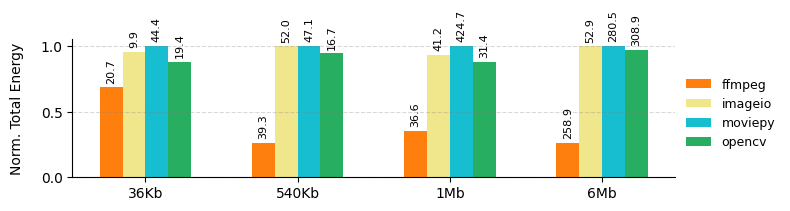

In [39]:
fig, ax = plt.subplots(figsize=(8, 2.2))  

for i, library in enumerate(libraries):
    
    subset = dfte[dfte['library'] == library]
    bar_positions = np.arange(len(sizes)) + i * bar_width
    bars = ax.bar(
        bar_positions, 
        subset['mean_energys'], 
        width=bar_width, 
        label=library, 
        color=color_mapping[library]
    )

    for bar, std in zip(bars, subset['std_energy']):
        height = bar.get_height()
        ax.annotate(
            f'{std:.1f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=8, rotation=90
        )

ax = bar_ax_style(ax, "Norm. Total Energy")

# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Metric data frame pre-processing 

In [40]:

dfm['video'] = dfm['video'].str.replace('.avi', '', case=False)

times_features = [
    "compute_time",
    "upload_time",
    "download_time"
]

# dfct : Data Frame Compute Time
dfct = (
    dfm.copy()
    .groupby(['library', 'video'], as_index=False)['compute_time']
    .agg(std_time='std', mean_time='mean')
    .assign(
        normalized_compute_time=lambda df: df.groupby('video')['mean_time'].transform(max_abs_scale),
        video=lambda df: pd.Categorical(df['video'], categories=video_order, ordered=True),
    )
    .sort_values(['library', 'video'])
)

# dfus : Data Frame Upload Size 
dfus = (
    dfm.copy()
    .groupby(['library', 'video'], as_index = False)['upload_size']
    .agg(std_size='std', mean_size='mean')
    .assign(
        normalized_upload_size=lambda df: df.groupby('video')['mean_size'].transform(max_abs_scale),
        video=lambda df: pd.Categorical(df['video'], categories=video_order, ordered=True),
    )
    .sort_values(['library', 'video'])
)

# dftt : Data Frame Total Time 
dftt = (
    dfm.copy()
    .assign(
        total_time=lambda df: df[times_features].sum(axis=1)
    )
    .groupby(['library', 'video'], as_index=False)['total_time']
    .agg(std_total_time='std', mean_time='mean')
    .assign(
        normalized_total_time=lambda df: df.groupby('video')['mean_time'].transform(max_abs_scale),
        video=lambda df: pd.Categorical(df['video'], categories=video_order, ordered=True),
    )
    .sort_values(['library', 'video'])
)
 
libraries = dfct['library'].unique() # Define the libraries and video sizes
video_sizes = dfct['video'].unique()

# dfct.head()


Compute Time

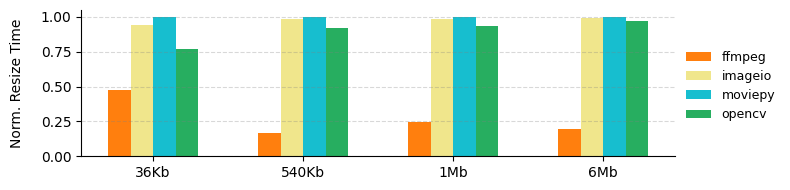

In [41]:
fig, ax = plt.subplots(figsize=(8, 2)) # Create a figure and axis

for i, library in enumerate(libraries):
    subset = dfct[dfct['library'] == library]
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, subset['normalized_compute_time'], width=bar_width, label=library, color=color_mapping[library])

ax = bar_ax_style(ax, "Norm. Resize Time")

# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Upload Size

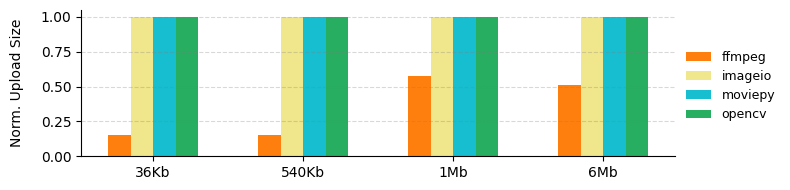

In [42]:
fig, ax = plt.subplots(figsize=(8, 2))

for i, library in enumerate(libraries):
    subset = dfus[dfus['library'] == library]
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, subset['normalized_upload_size'], width=bar_width, label=library, color=color_mapping[library])

ax = bar_ax_style(ax, "Norm. Upload Size")

plt.tight_layout()
plt.show()


Total Time

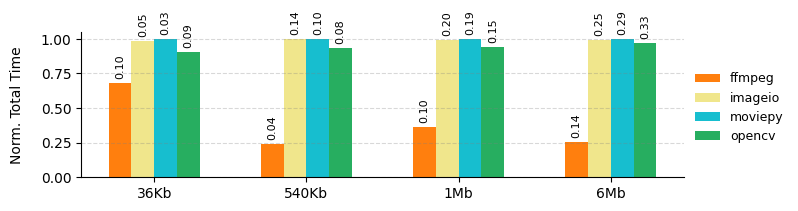

In [43]:
fig, ax = plt.subplots(figsize=(8, 2.2))

for i, library in enumerate(libraries):
    subset = dftt[dftt['library'] == library]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['normalized_total_time'], width=bar_width, label=library, color=color_mapping[library])

    for bar, std in zip(bars, subset['std_total_time']):
        height = bar.get_height()
        ax.annotate(f'{std:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, rotation=90)

ax = bar_ax_style(ax, "Norm. Total Time")

plt.tight_layout()
plt.show()